In [25]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:

import os

def find_and_display_first_jpg(base_path):
    # Walk through the directory
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.jpg'):
                # Get the full path of the first jpg file
                first_jpg_path = os.path.join(root, file)
                # Display the image
                display(Image(filename=first_jpg_path))
                return
        print('ya yunus hocam ya')

# Define the base path
base_path = '/home/umut.aydin/custom-models-somaset/body-shape-clf-w-somaset'

# Call the function
find_and_display_first_jpg(base_path)

In [ ]:
train_data_dir = '/content/drive/MyDrive/fakeORreal/train'
test_data_dir = '/content/drive/MyDrive/fakeORreal/test'

In [ ]:
class FakeOrReal(Dataset):
    def __init__(self, folder, isTrain = True):
        fake = glob(folder+'/FAKE/*.jpg')
        real = glob(folder+'/REAL/*.jpg')
        self.fpaths = fake[:] + real[:]
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-2].startswith('REAL') for fpath in self.fpaths]
        self.isTraining = isTrain
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        if self.isTraining:
          transforms = v2.Compose([
              v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
              v2.RandomPerspective(distortion_scale=0.4, p=0.5),
              v2.RandomRotation(degrees=(0, 10)),
              v2.ColorJitter(brightness=0.1, hue=0.1),
              v2.GaussianBlur(kernel_size=(7, 7), sigma=(.01, 1.0)),
              v2.RandomHorizontalFlip(p=0.5),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ])
        else:
           transforms = v2.Compose([
              v2.RandomResizedCrop(size=(224, 224), scale=(1.0, 1.0), antialias=True),
              v2.ToDtype(torch.float32, scale=True),
              v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          ])
        im = transforms(im)

        return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
data = FakeOrReal(train_data_dir, isTrain=True)

In [ ]:
len(data)

99994

tensor([1.])


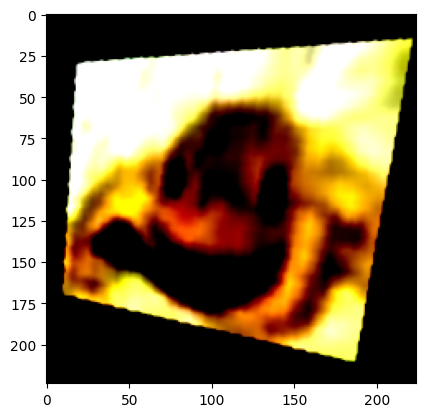

In [ ]:
im, label = data[100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def get_model(learning_rate = 1e-4, model_name = 'resnet_18', requires_grad_ratio=0, weight_decay=0, optimizer_in=torch.optim.Adam, loss_type=0):
    weights = None
    model = None
    def determine_train_layers(model, requires_grad_ratio):
      total_num_layers = 0
      for param in model.parameters():
        param.requires_grad = False
        total_num_layers += 1
      # 2 layers are overwritten manually in the following part
      num_layers_grad = total_num_layers - 2
      num_layers_requires_grad = num_layers_grad * requires_grad_ratio
      layer_counter_grad = 0
      if num_layers_requires_grad > 0:
        layer_counter = 0
        for param in model.parameters():
          if layer_counter >= num_layers_grad - num_layers_requires_grad:
            param.requires_grad = True
          else:
            param.requires_grad = False
          layer_counter += 1
        for param in model.parameters():
          if param.requires_grad == True:
             layer_counter_grad += 1
      print("Total # Layers: " + str(total_num_layers) + " Layers Requires Training: " + str(layer_counter_grad) + "(2 for the last two layers)")


    if model_name == 'resnet_18':
      print("Model: RESNET18")
      model = models.resnet18(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.fc = nn.Sequential(nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'resnet_34':
      print("Model: RESNET34")
      model = models.resnet34(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.fc = nn.Sequential(nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'resnet_50':
      print("Model: RESNET50")
      model = models.resnet50(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.fc = nn.Sequential(nn.Flatten(),
      nn.Linear(2048, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'mobilenet_v3_large':
      print("Model: MobileNetV3Large")
      model = models.mobilenet_v3_large(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.classifier = nn.Sequential(nn.Flatten(),
      nn.Linear(960, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'efficientnet_b1':
      print("Model: EFFICIENTNET_B1")
      model = models.efficientnet_b1(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.classifier = nn.Sequential(nn.Flatten(),
      nn.Linear(1280, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'efficientnet_v2_m':
      print("Model: EFFICIENTNET_V2M")
      model = models.efficientnet_v2_m(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.classifier = nn.Sequential(nn.Flatten(),
      nn.Linear(1280, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid())
    elif model_name == 'swin_t':
      print("Model: SWIM_T")
      model = models.swin_t(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.head = nn.Sequential(nn.Linear(in_features=768, out_features=1, bias=True),
                                 nn.Sigmoid())
    elif model_name == 'swin_s':
      print("Model: SWIM_S")
      model = models.swin_s(weights='DEFAULT')
      determine_train_layers(model, requires_grad_ratio)
      model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
      model.head = nn.Sequential(nn.Linear(in_features=768, out_features=1, bias=True),
                                 nn.Sigmoid())
    else:
      print("UNKNOWN MODEL")
      assert()


    loss_fn = nn.BCELoss()
    optimizer = optimizer_in(model.parameters(), lr= learning_rate, weight_decay=weight_decay)
    return model.to(device), loss_fn, optimizer

In [ ]:
model, loss_fn, optimizer = get_model(model_name = 'swin_t', requires_grad_ratio=0.0)
summary(model, torch.zeros(1,3,224,224))

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train = FakeOrReal(train_data_dir, isTrain=True)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = FakeOrReal(test_data_dir, isTrain=False)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(learning_rate = 1e-4, model_name = 'mobilenet_v3_large', requires_grad_ratio=0, weight_decay=0, optimizer_in=torch.optim.Adam, loss_type=0)

Model: MobileNetV3Large
Total # Layers: 174 Layers Requires Training: 0(2 for the last two layers)


In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
NUM_EPOCH = 10
for epoch in range(NUM_EPOCH):
    print(f" epoch {epoch + 1}/{NUM_EPOCH}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    print("train_loss: ", train_epoch_loss, " train_accuracy: ", train_epoch_accuracy, " valid accuracy: ", val_epoch_accuracy)

 epoch 1/5


In [ ]:
epochs = np.arange(NUM_EPOCH)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.9,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()